# Correlate Temperature and S5P L3 O3 VCD

## Do some setup

In [6]:
pip install netCDF4

     |████████████████████████████████| 5.4 MB 1.3 MB/s eta 0:00:01
  Using cached cftime-1.6.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
Note: you may need to restart the kernel to use updated packages.


In [43]:
pip install scipy

  Using cached scipy-1.10.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.5 MB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install mpl-scatter-density

In [1]:
import xarray

In [2]:
import datetime

In [3]:
from pystac_client import Client

In [4]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy

In [5]:
from odc.stac import stac_load
from odc.geo  import resxy_

In [ ]:
import mpl_scatter_density

## Access locally stored dataset (temperature)

In [6]:
t = xarray.open_dataset("ECMWF_temperature_2023-09-20_2023-09-26_plus.nc")

In [7]:
t

<xarray.Dataset>
Dimensions:  (time: 7, lon: 720, lat: 360, level: 25)
Coordinates:
  * time     (time) datetime64[ns] 2023-09-20T12:00:00 ... 2023-09-26T12:00:00
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * level    (level) float64 1.0 2.0 3.0 5.0 7.0 ... 900.0 925.0 950.0 1e+03
Data variables:
    t        (time, level, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.9rc1 (https://mpimet.mpg...
    Conventions:  CF-1.6
    history:      Wed Oct 04 15:25:12 2023: cdo remapnn,global_0.5 test_stac_...
    CDO:          Climate Data Operators version 1.9.9rc1 (https://mpimet.mpg...

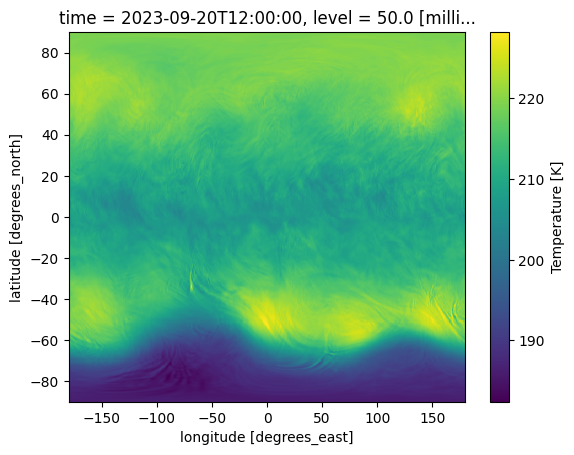

In [8]:
t.t.isel(time=0,level=8).plot()

In [9]:
# Use level 7 = 30 hPa for any further analysis

## Determine bounding box and period of locally stored dataset

In [10]:
bbox = [float(t.lon[0].data), float(t.lat[0].data), float(t.lon[t.lon.shape[0]-1].data), float(t.lat[t.lat.shape[0]-1].data)]

print ("Bounding Box (W, S, N, E) [degrees]: ", bbox)

Bounding Box (W, S, N, E) [degrees]:  [-179.75, -89.75, 179.75, 89.75]


In [11]:
period_start_dt = datetime.datetime.strptime(str(t.time[0].data), "%Y-%m-%dT%H:%M:%S.%f000")
period_end_dt   = datetime.datetime.strptime(str(t.time[t.time.shape[0]-1].data), "%Y-%m-%dT%H:%M:%S.%f000")

period = [period_start_dt.strftime("%Y-%m-%d"), period_end_dt.strftime("%Y-%m-%d")]

print ("Period: ", period_start_dt, " to ", period_end_dt)

Period:  2023-09-20 12:00:00  to  2023-09-26 12:00:00


In [12]:
resolution_x = float(360. / t.lon.shape[0])
resolution_y = float(180. / (t.lat.shape[0]))
resolution = (resolution_x, resolution_y)

print ("Resolution [degrees]: ", resolution_x, resolution_y)

Resolution [degrees]:  0.5 0.5


## Discover S5P L3 Ozone VCD

In [13]:
stacapi_endpoint = "https://geoservice.dlr.de/eoc/ogc/stac/"
collections = ["S5P_TROPOMI_L3_P1D_O3"]

In [14]:
catalog = Client.open(
    url=stacapi_endpoint,
    ignore_conformance=True
)

/localhome/meyerarn/Projekte/sandbox/inpuls-s5p-ozone-hole-size/py-env-inpuls/lib/python3.8/site-packages/pystac_client/client.py:176: FutureWarning: The `ignore_conformance` option is deprecated and will be removed in the next major release. Instead use `set_conforms_to` or `add_conforms_to` to control behavior.
  warnings.warn(


In [15]:
o3_items = catalog.search(
    collections=collections, 
    datetime=period, 
    bbox=bbox,
    method="GET", 
    filter_lang="cql2-text",
    max_items=1000
).get_all_items()

/localhome/meyerarn/Projekte/sandbox/inpuls-s5p-ozone-hole-size/py-env-inpuls/lib/python3.8/site-packages/pystac_client/item_search.py:850: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


In [16]:
o3_items.items

[<Item id=S5P_DLR_NRTI_01_040100_L3_O3_20230926>,
 <Item id=S5P_DLR_NRTI_01_040100_L3_O3_20230925>,
 <Item id=S5P_DLR_NRTI_01_040100_L3_O3_20230924>,
 <Item id=S5P_DLR_NRTI_01_040100_L3_O3_20230923>,
 <Item id=S5P_DLR_NRTI_01_040100_L3_O3_20230922>,
 <Item id=S5P_DLR_NRTI_01_040100_L3_O3_20230921>,
 <Item id=S5P_DLR_NRTI_01_040100_L3_O3_20230920>]

## Load S5P L3 O3 VCD for given period and given resolution

In [17]:
%%time

o3 = stac_load(
    o3_items,
    bands=["o3"],
    crs="EPSG:4326",
    resolution=resxy_(0.5,0.5), # resxy_(resolution_x, resolution_y), # 0.0174532925199433
    dtype="float",
    lon=(-180, 180),
    lat=(bbox[1], bbox[3]))

print ("Data is extracted on the server and downloaded to local storage.")

Data is extracted on the server and downloaded to local storage.
CPU times: user 381 ms, sys: 608 ms, total: 989 ms
Wall time: 2.22 s


In [18]:
o3

<xarray.Dataset>
Dimensions:      (latitude: 360, longitude: 720, time: 7)
Coordinates:
  * latitude     (latitude) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude    (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2023-09-20 2023-09-21 ... 2023-09-26
Data variables:
    o3           (time, latitude, longitude) float64 9.969e+36 ... 9.969e+36

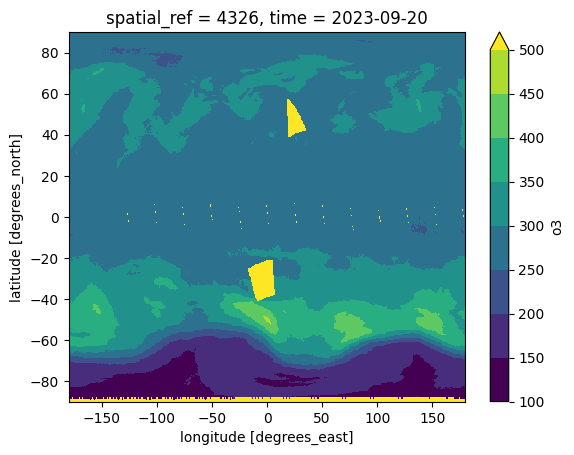

In [19]:
itime = 0
o3.o3.isel(time=itime).plot(levels=[100,150,200,250,300,350,400,450,500])

## Analysis #1: Search for minimum values of temperature on each day

In [20]:
for itime in range(0,6):
    x = o3.o3.isel(time=itime).where(o3.o3.isel(time=itime)==o3.o3.isel(time=itime).min(), drop=True)
    print (x)

<xarray.DataArray 'o3' (latitude: 1, longitude: 1)>
array([[127.09784698]])
Coordinates:
  * latitude     (latitude) float64 -88.25
  * longitude    (longitude) float64 171.2
    spatial_ref  int32 4326
    time         datetime64[ns] 2023-09-20
Attributes:
    nodata:   9.969209968386869e+36
<xarray.DataArray 'o3' (latitude: 1, longitude: 1)>
array([[118.85075378]])
Coordinates:
  * latitude     (latitude) float64 -80.75
  * longitude    (longitude) float64 -103.8
    spatial_ref  int32 4326
    time         datetime64[ns] 2023-09-21
Attributes:
    nodata:   9.969209968386869e+36
<xarray.DataArray 'o3' (latitude: 1, longitude: 1)>
array([[116.53308105]])
Coordinates:
  * latitude     (latitude) float64 -74.25
  * longitude    (longitude) float64 -66.75
    spatial_ref  int32 4326
    time         datetime64[ns] 2023-09-22
Attributes:
    nodata:   9.969209968386869e+36
<xarray.DataArray 'o3' (latitude: 1, longitude: 1)>
array([[117.16448212]])
Coordinates:
  * latitude     (latitude)

## Analysis #2: Perform correlation between S5P L3 O3 VCD and Temperature at 30hPa

In [21]:
correlation_x = o3.o3.values

In [22]:
correlation_y = t.t.values

In [31]:
%%time

NORTHERN_BOUNDARY = -60. # degrees N
O3MAX_VALUE = 1000. # DU

x = numpy.zeros((0), dtype=float)
y = numpy.zeros((0), dtype=float)

for xt in range(0,correlation_x.shape[0]):
    for i in range(0,correlation_x.shape[1]):
        if o3.latitude[i] < NORTHERN_BOUNDARY:
            for j in range(0, correlation_x.shape[2]):
                if correlation_x[xt,i,j] < O3MAX_VALUE:
                    x = numpy.append(x, correlation_x[xt,i,j])
                    y = numpy.append(y, correlation_y[xt,7,i,j])

CPU times: user 58 s, sys: 6.71 ms, total: 58 s
Wall time: 58 s


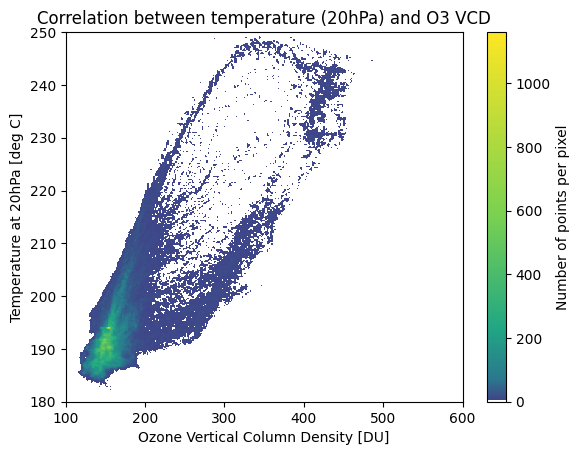

In [43]:
from matplotlib.colors import LinearSegmentedColormap

# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-40, '#440053'),
    (0.001, '#404388'),
    (0.06, '#2a788e'),
    (0.2, '#21a784'),
    (0.5, '#78d151'),
    (1, '#fde624'),
], N=256)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
density = ax.scatter_density(x, y, cmap=white_viridis)
ax.set_xlim((100,600))
ax.set_ylim((180,250))
ax.set_xlabel("Ozone Vertical Column Density [DU]")
ax.set_ylabel("Temperature at 20hPa [deg C]")
ax.set_title("Correlation between temperature (20hPa) and O3 VCD")
fig.colorbar(density, label='Number of points per pixel')
plt.show()

## Show correlation between S5P L3 O3 VCD and Temperature (30 hPa)

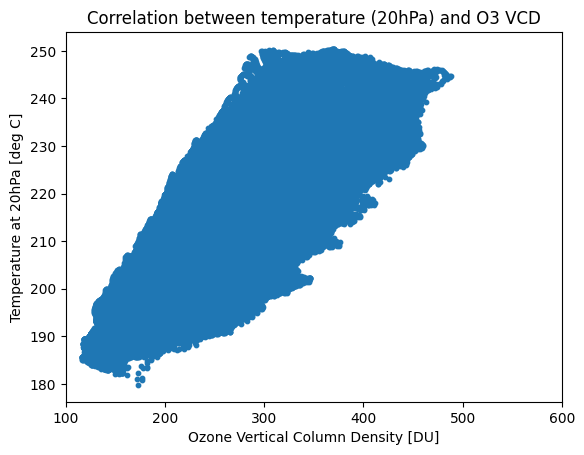

In [44]:
fig, ax = plt.subplots()
ax.scatter(x, y, s=10)
ax.set_xlim((100,600))
ax.set_title("Correlation between temperature (20hPa) and O3 VCD")
ax.set_xlabel("Ozone Vertical Column Density [DU]")
ax.set_ylabel("Temperature at 20hPa [deg C]")
plt.show()